In [1]:
#| default_exp triangular

In [ ]:
#| export

import numpy as np
import matplotlib.pyplot as plt

import igl

from scipy import spatial

In [3]:
#| export

import jax
import jax.numpy as jnp

In [ ]:
#| export

from jaxtyping import Float, Int 
from pathlib import Path

import dataclasses

In [5]:
#| export

from triangulax import trigonometry as trig

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [ ]:
#| hide

%load_ext jaxtyping 
%jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving). For those, disable type checks

## Loading, processing, and saving triangular meshes

`triangulax` is a library for working with triangular meshes using JAX. In this notebook, however, we define some tools for loading, processing, and saving triangular meshes _outside_ of JAX. The dataclass `TriMesh` keeps the different pieces of a triangulation in one place. The use case of this module is to interface with JAX-external code, like the excellent `igl` geometry processing library, prepare initial conditions for simulations, etc. The data structure for JAX-based code is defined in the `mesh` module, notebook 03.

The simplest way to represent a triangulation is by a list of vertices and faces (triangles):

1. A set of vertices, i.e., a $(N_V, 2)$ dimensional array datatype `float`.
2. A set of faces, a $(N_F, 3)$ dimensional array of datatype `int`. Each row is an ordered triple of vertex indices that form a face.
3. (Optional) A set of face centers, a $(N_F, 2)$ dimensional array of datatype `float`. An entry is the position of the dual vertex of a the triangulation face (think circumcenter).

To read and write, we use the `.obj`-file format. We will also make heavy use of the `igl` geometry processing library. 
The `TriMesh` class is a "holder" for loading, saving, visualizing, etc meshes, and not to be used for numerical computation. .

### Cell tilings and triangular meshes

One use case of `triangulax` is simulations of 2D cell tilings. The simplest way to represent a cell tiling is by its _dual_ triangular mesh (one triangulation vertex per cell). We will represent cell tilings by 2D Voronoi tessellations and variants thereof (like power diagrams). This means that we can represent the cell network as a 2D triangulation with vertices $V$ and faces $F$. We will first consider the case where the number of vertices does not change. Cells can, however, rearrange (T1-transitions/edge flips in the triangulation). Such flips also conserve the number of faces and edges.

In [6]:
#| export

@dataclasses.dataclass(init=True, repr=False, eq=False, frozen=False, slots=False)
class TriMesh:
    """
    Simple class for reading, holding, transforming, and saving triangular meshes.
    
    A TriMesh comprises vertices and faces, describing a surface in 2d or 3d. 
    In addition, there can be a 2d/3d position for every face (think Voronoi dual of the triangulation).
    
    Vertices and faces are jnp.arrays. Each face is a triple of vertex indices.
    Vertices and faces are ordered - this is essential so that we know which attribute
    vector entry goes to which vector/edge/face. Faces in a face are assumed to be in counter-clockwise order.

    Meshes are read and written in the .obj format (https://en.wikipedia.org/wiki/Wavefront_.obj_file).
    To store _face_positions_, we abuse the `vn` (vertex normal) entry of an .obj file. Face
    positions will be written in order corresponding to faces.
    When reading from an .obj file, edges are recomputed from faces and initialized in alpha-numerical ordering.
    An .obj file expects 3d positions; the z-position is ignored when reading and set to 0 when writing for 2d meshes.

    **Attributes**

    dim : int = 2
    
    vertices : Float[jax.Array, "n_vertices dim"]

    faces : Int[jax.Array, "n_faces 3"]

    face_positions : Float[jax.Array, "n_faces dim"]

    **Property methods (use like attributes)**

    n_vertices : int

    has_inf_vertex : bool

    **Static methods**
    
    read_obj : str -> TriMesh

    **Methods**

    write_obj : str -> None
        
    """
    vertices : Float[jax.Array, "n_vertices dim"]
    faces : Int[jax.Array, "n_faces 3"]
    face_positions : Float[jax.Array, "n_faces dim"] | None = None

    def set_voronoi(self):
        """Set face positions to the Voronoi dual of the faces is computed."""
        self.face_positions = jax.vmap(trig.get_circumcenter)(*[self.vertices[fcs] for fcs in self.faces.T])
        
    @staticmethod  
    def read_obj(filename: str | Path, read_face_positions: bool = False, dim: int = 2) -> "TriMesh":
        """
        Read vertices, texture vertices, normals, and faces from an obj file.

        Indices of returned faces start at 0. See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        Intended for .obj files containing a single object only.

        Parameters
        ----------
        filename : str
            filename
        read_face_positions : bool
            If True, use the vertex normal entries `vn` in the .obj file
            as face positions. This is an abuse of the .obj file format
            so only use this for files written by this code.
        dim : int
            Dimension - can be 2 or 3. If 2, the z-coordinate is ignored.
        
        Returns
        -------
        mesh: TriMesh
        """
        vertices, _, normals, faces, _, _ = igl.readOBJ(filename)
        if read_face_positions:
            return TriMesh(jnp.array(vertices[:,:dim]), jnp.array(faces), face_positions=jnp.array(normals[:,:dim]))
        mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.float64), jnp.array(faces, dtype=jnp.int64), face_positions=None)
        mesh.set_voronoi()
        return mesh
        
    def write_obj(self, filename: str | Path, save_face_positions: bool=True) -> None:
        """
        Write mesh to .obj format.

        Parameters
        ----------
        filename : str
            filename to save to
        save_face_positions : bool
            If true, face positions are written to the `vn` line of .obj files.
            
        Returns
        -------
        None
        """
        if self.dim == 2:
            vlines = ["v {} {} 0\n".format(*v) for v in self.vertices]
            vnlines = ["vn {} {} 0\n".format(*vn) for vn in self.face_positions]
        elif self.dim == 3:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            vnlines = ["vn {} {}\n".format(*vn) for vn in self.face_positions]
        flines = ["f {} {} {}\n".format(*[int(v+1) for v in fc]) for fc in self.faces]

        with open(filename, 'w') as f:
            f.writelines(vlines)
            if save_face_positions:
                f.writelines(vnlines)               
            f.writelines(flines)
        return None

    @property
    def has_inf_vertex(self) -> bool:
        return jnp.isinf(self.vertices).any()

    @property
    def n_vertices(self) -> int:
        return self.vertices.shape[0]

    @property
    def dim(self) -> int:
        return self.vertices.shape[-1]



In [8]:
# test reading a mesh

mesh = TriMesh.read_obj("test_meshes/disk.obj")

/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.float64), jnp.array(faces, dtype=jnp.int64), face_positions=None)
  o flat_tri_ecmc
/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.

In [9]:
# test computing the circumcenter of each face. should be equidistant to all vertex points

dists = jnp.stack([jnp.linalg.norm(mesh.vertices[mesh.faces[:,i]]-mesh.face_positions, axis=1) for i in [0,1,2]], axis=1)

jnp.allclose(dists[:,0], dists[:,1]) and jnp.allclose(dists[:,1], dists[:,2])

Array(True, dtype=bool)

In [10]:
# test writing face positions to vn entries

mesh = TriMesh.read_obj("test_meshes/disk.obj")
filename = "test_meshes/disk_write_test.obj"
mesh.write_obj(filename, save_face_positions=True)
mesh = TriMesh.read_obj(filename, read_face_positions=True)

/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.float64), jnp.array(faces, dtype=jnp.int64), face_positions=None)
  o flat_tri_ecmc
/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.

### Creating meshes and plotting

Some functions to create meshes based on the Delaunay triangulation of a point set.

1. Poisson (vertices placed uniformly at random) in disk or box
2. Ginibre (vertices placed at uniform with self-repulsion)
3. Triangular lattice

Some functions for plotting meshes:

1. Plot triangulation with vertex and face labels (for debugging)
2. Plot cell tesselation

In [11]:
#| export

def generate_ginibre_points(n_vertices: int) -> Float[jax.Array, "n_vertices 2"]:
    """Sample n_vertices points from the Ginibre ensemble. Points are scaled to unit disk."""
    M = np.random.normal(size=(n_vertices, n_vertices)) + 1j*np.random.normal(size=(n_vertices, n_vertices))
    vals = np.linalg.eigvals(M)
    pos = np.stack([vals.real, vals.imag], axis=-1)
    # rescale to unit disk
    pos /= np.linalg.norm(pos, axis=1).mean()
    return jnp.array(pos)

def generate_poisson_points(n_vertices: int, limit_x: float = 1, limit_y: float = 1
                           ) -> Float[jax.Array, "n_vertices 2"]:
    """Sample n_vertices points from the Poisson ensemble in rectangle
    [-limit_x/2, limit_x/2] * [-limit_y/2, limit_y/2]."""
    pos = np.stack([np.random.uniform(size=n_vertices, low=-limit_x/2, high=limit_x/2),
                    np.random.uniform(size=n_vertices, low=-limit_y/2, high=limit_y/2)])
    return jnp.array(pos)

def generate_triangular_lattice(nx: int, ny: int) -> Float[jax.Array, "nx*ny 2"]:
    """Get points for rectangular patch of triangular lattice with nx, ny points."""
    y = np.arange(0, ny)*np.sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2
    Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))    
    return jnp.array(pts.T)

(np.float64(-1.6629634499549866),
 np.float64(1.632395327091217),
 np.float64(-1.5740285992622376),
 np.float64(1.561158287525177))

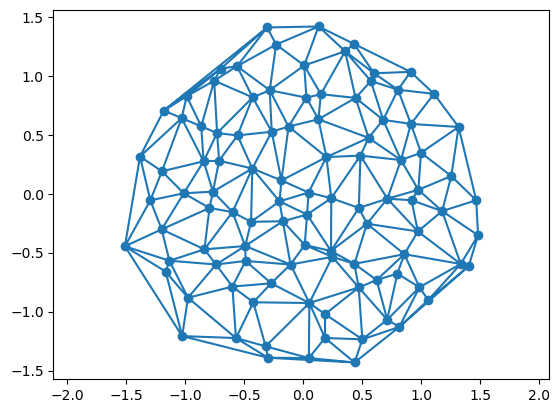

In [12]:
#points = generate_triangular_lattice(10, 10)

points = generate_ginibre_points(100)
mesh = TriMesh(vertices=points, faces=jnp.array(spatial.Delaunay(points).simplices))

plt.triplot(*points.T, mesh.faces)

plt.scatter(*points.T)
plt.axis("equal")

### Elementary book-keeping using list-of-triangles data structure

In [22]:
#| export

# find the vertices and faces which are adjacent to a given vertex, in the correct counter-clockwise order.

def get_adjacent_vertex_indices(faces: Int[jax.Array, "n_faces 3"],
                                n_vertices: int) -> list[Int[jax.Array, " n_neighbors"]]:
    """For each vertex, get the indices of the adjacent vertices in correct order.
    For boundary vertices, this list contains the vertex itself."""
    faces = np.array(faces)
    vf, ni = igl.vertex_triangle_adjacency(faces, n=n_vertices)
    adjacent_faces = [vf[a:b] for a, b in zip(ni[:-1], jnp.roll(ni, -1)[:-1])]
    adjacent_vertices = [jnp.array(igl.boundary_loop(faces[fcs])) for fcs in adjacent_faces]
    return adjacent_vertices

In [23]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")

neighbors = get_adjacent_vertex_indices(mesh.faces, mesh.n_vertices)

/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.float64), jnp.array(faces, dtype=jnp.int64), face_positions=None)
  o flat_tri_ecmc
/var/folders/vm/1jl6rjln6n9cjt54vsr9n4800000gr/T/ipykernel_46976/2048334256.py:80: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  mesh = TriMesh(jnp.array(vertices[:,:dim], dtype=jnp.